# Question 1
Read data from patient notes.

In [11]:
#%pip install textblob
import pandas as pd
import re
#from textblob import TextBlob
#from spellchecker import SpellChecker

# Read the CSV file
df = pd.read_csv('patient_notes.csv')

# Case Conversion
df['pn_history'] = df['pn_history'].str.lower()

print(df)

       pn_num  case_num                                         pn_history
0           0         0  17-year-old male, has come to the student heal...
1           1         0  17 yo male with recurrent palpitations for the...
2           2         0  dillon cleveland is a 17 y.o. male patient wit...
3           3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4           4         0  17yo male with no pmh here for evaluation of p...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a 20 yo female presenting w/ the...
42142   95331         9  a 20 yo f came complain a dull 8/10 headache t...
42143   95332         9  ms. madden is a 20yo female who presents with ...
42144   95333         9  stephanie madden is a 20 year old woman compla...
42145   95334         9  patient is a 20 yo f who presents with a heada...

[42146 rows x 3 columns]


### i. Case Conversion and iii.	Correcting Typos and Spelling
Removing Puncutation and Special Characters seems would influence standardizing formatsand handling contractions parts, so it is moved to later.

We tried the TextBlob. But after taking 17 minutes that the first 100 rows have not been handled, we plan to try some other ways.

Then I tried the symspellpy. However, it cannot be installed by conda, only can be dealt with by pip. So I move to SpaCy.

Then I found the pyspellchecker is something I must use with SpaCy and also not able to installed by conda. So I return to symspellpy.

In [12]:
#pip install symspellpy
from multiprocessing import Pool
import pandas as pd
import numpy as np
from symspellpy import SymSpell, Verbosity
import pkg_resources

# Initialize and load SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Function to correct spelling in a sentence
def correct_spelling(text):
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    return suggestions[0].term if suggestions else text

# Function to apply correct_spelling to a Series
def apply_correct_spelling(series):
    return series.apply(correct_spelling)

# Function to parallelize
def parallelize_dataframe(df, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df_combined = pd.concat(pool.map(apply_correct_spelling, df_split))
    pool.close()
    pool.join()
    return df_combined

# Applying the function in parallel
# df_head = df.head(1000)
if __name__ == 'main':
	df['pn_history'] = parallelize_dataframe(df['pn_history'])
print(df)


       pn_num  case_num                                         pn_history
0           0         0  17-year-old male, has come to the student heal...
1           1         0  17 yo male with recurrent palpitations for the...
2           2         0  dillon cleveland is a 17 y.o. male patient wit...
3           3         0  a 17 yo m c/o palpitation started 3 mos ago; \...
4           4         0  17yo male with no pmh here for evaluation of p...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a 20 yo female presenting w/ the...
42142   95331         9  a 20 yo f came complain a dull 8/10 headache t...
42143   95332         9  ms. madden is a 20yo female who presents with ...
42144   95333         9  stephanie madden is a 20 year old woman compla...
42145   95334         9  patient is a 20 yo f who presents with a heada...

[42146 rows x 3 columns]


### 4th Standardizing Formats 5th Handling Contractions
Standardizing Formats for numbers: "17", “17-year-old”, “3-4”, or “17yo”

Handling Contractions: Expanding contractions"

In [13]:
# pip install inflect
# pip install contractions
import inflect
import contractions

# Create an engine for inflect
p = inflect.engine()

# Standardizing Formats "17", “17-year-old”, “3-4”, or “17yo”
def convert_numbers_in_string(s):
    # Find all numbers in the string
    numbers_in_words = re.findall(r'\b\d+\b', s)
    numbers_in_parts = re.findall(r'\d+', s)

    # For each number
    for number in numbers_in_words:
        # Convert the number to words
        word = p.number_to_words(number)
        # Replace the number with the word in the string
        s = re.sub(r'\b' + number + r'\b', word, s)

    for number in numbers_in_parts:
        # Convert the number to words
        word = p.number_to_words(number)
        # Replace the number with the word (followed by a space) in the string
        s = re.sub(number, word + " ", s)

    return s

# Handling Contractions: Expanding contractions" 
def expand_contractions(text):
    # Define a dictionary of contractions and their expanded forms
    custom_contractions = {
        "yo": "year old",
        "y.o.": "year old",
        "y/o": "year old",
        "y": "year",
        "yr": "year",
        "f": "female",
        "m": "male",
        "mo": "month",
        "yr": "year",
        "c/o": "complains of",
        "c/of": "complains of",
        "c/m": "complains of",
        "cc": "chief complaint",
        "h/o": "history of",
        "pt": "patient",
        "w": "week",
        "wk": "week",
        "hrs": "hours",
        "hx": "history",
        "pmh": "past medical history",
        "pmhx": "past medical history",
        "psh": "past surgical history",
        "psurghx": "past surgical history",
        "pshh": "past surgical history",
        "meds": "medications",
        "hosp": "hosipital",
        "fh": "Family history",
        "fhx": "Family history",
        "fmh": "Family history",
        "sh":"social history",
        "soc": "social history",
        "Rx": "prescription",
        "ros":"review of systems",
        "hpi": "history of present illness"
    }

    # First, use the contractions library to expand common English contractions
    text = contractions.fix(text)

    # Then, handle the custom contractions
    # Split the text into words
    words = text.split()
    # For each word in the text
    for i in range(len(words)):
        # If the word is a contraction
        if words[i] in custom_contractions:
            # Replace the contraction with its expanded form in the text
            words[i] = custom_contractions[words[i]]
    # Join the words back into a text string
    return ' '.join(words)



def process_data(df):
    # Fill NaN values with a default value
    df.fillna('Unknown', inplace=True)
    
    # Convert columns to string type
    df['pn_history'] = df['pn_history'].astype(str)

    df['pn_history'] = df['pn_history'].apply(convert_numbers_in_string)

    # Apply the function to the 'pn_history' column
    df['pn_history'] = df['pn_history'].apply(expand_contractions)

    return df

# Apply the function to the DataFrame
df = process_data(df)

# Write the data back to the CSV file
# df.to_csv('data.csv', index=False)
print(df)

       pn_num  case_num                                         pn_history
0           0         0  seventeen-year-old male, has come to the stude...
1           1         0  seventeen year old male with recurrent palpita...
2           2         0  dillon cleveland is a seventeen year old male ...
3           3         0  a seventeen year old male complains of palpita...
4           4         0  seventeen year old male with no past medical h...
...       ...       ...                                                ...
42141   95330         9  ms. madden is a twenty year old female present...
42142   95331         9  a twenty year old female came complain a dull ...
42143   95332         9  ms. madden is a twenty year old female who pre...
42144   95333         9  stephanie madden is a twenty year old woman co...
42145   95334         9  patient is a twenty year old female who presen...

[42146 rows x 3 columns]


### 2nd. Removing Puncutation and Special Characters parts.

In [14]:
# Removing Punctuation and Special Characters
df['pn_history'] = df['pn_history'].str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)

print(df)

       pn_num  case_num                                         pn_history
0           0         0  seventeen year old male  has come to the stude...
1           1         0  seventeen year old male with recurrent palpita...
2           2         0  dillon cleveland is a seventeen year old male ...
3           3         0  a seventeen year old male complains of palpita...
4           4         0  seventeen year old male with no past medical h...
...       ...       ...                                                ...
42141   95330         9  ms  madden is a twenty year old female present...
42142   95331         9  a twenty year old female came complain a dull ...
42143   95332         9  ms  madden is a twenty year old female who pre...
42144   95333         9  stephanie madden is a twenty year old woman co...
42145   95334         9  patient is a twenty year old female who presen...

[42146 rows x 3 columns]


### 6th. Stemming
This part would apply the stemming. I choose LancasterStemmer because it seems to be most efficient to find the root and would reduce the number of tokens, which make the last cluster easier.

In [15]:
import pandas as pd
import re
from nltk.stem import LancasterStemmer

# Create an instance of LancasterStemmer
stemmer = LancasterStemmer()

# Apply LancasterStemmer to the pn_history column
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([stemmer.stem(word) for word in re.findall(r'\w+', x)]))

# Print the updated dataframe
print(df)


       pn_num  case_num                                         pn_history
0           0         0  seventeen year old mal has com to the stud hea...
1           1         0  seventeen year old mal with recur palpit for t...
2           2         0  dillon cleveland is a seventeen year old mal p...
3           3         0  a seventeen year old mal complain of palpit st...
4           4         0  seventeen year old mal with no past med hist h...
...       ...       ...                                                ...
42141   95330         9  ms mad is a twenty year old fem pres w the wor...
42142   95331         9  a twenty year old fem cam complain a dul eight...
42143   95332         9  ms mad is a twenty year old fem who pres with ...
42144   95333         9  stephany mad is a twenty year old wom complain...
42145   95334         9  paty is a twenty year old fem who pres with a ...

[42146 rows x 3 columns]


### 6th. Lemmatizer
Apply lemmatizer.

In [16]:
import nltk

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in re.findall(r'\w+', x)]))
print(df)

       pn_num  case_num                                         pn_history
0           0         0  seventeen year old mal ha com to the stud heal...
1           1         0  seventeen year old mal with recur palpit for t...
2           2         0  dillon cleveland is a seventeen year old mal p...
3           3         0  a seventeen year old mal complain of palpit st...
4           4         0  seventeen year old mal with no past med hist h...
...       ...       ...                                                ...
42141   95330         9  m mad is a twenty year old fem pres w the wors...
42142   95331         9  a twenty year old fem cam complain a dul eight...
42143   95332         9  m mad is a twenty year old fem who pres with a...
42144   95333         9  stephany mad is a twenty year old wom complain...
42145   95334         9  paty is a twenty year old fem who pres with a ...

[42146 rows x 3 columns]


### 7th. Stop list
Apply a stop word list to filter out unnecessary words.

In [18]:
from nltk.corpus import stopwords

# Download the stopwords if not already present
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Apply stop word filtering to the pn_history column
df['pn_history'] = df['pn_history'].apply(lambda x: ' '.join([word for word in re.findall(r'\w+', x) if word not in stop_words]))

# Print the updated dataframe
print(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


       pn_num  case_num                                         pn_history
0           0         0  seventeen year old mal ha com stud heal clin c...
1           1         0  seventeen year old mal recur palpit past three...
2           2         0  dillon cleveland seventeen year old mal paty s...
3           3         0  seventeen year old mal complain palpit start t...
4           4         0  seventeen year old mal past med hist evalu pal...
...       ...       ...                                                ...
42141   95330         9  mad twenty year old fem pres w worst ha lif un...
42142   95331         9  twenty year old fem cam complain dul eight ten...
42143   95332         9  mad twenty year old fem pres headach day dur w...
42144   95333         9  stephany mad twenty year old wom complain head...
42145   95334         9  paty twenty year old fem pres headach said ha ...

[42146 rows x 3 columns]


# Question 2
### a.CountVectorizer
Use CountVectorizer.

In [19]:
#conda install -c conda-forge scikit-learn
#pip install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the "pn_history" column
dtm = vectorizer.fit_transform(df['pn_history'])

# Convert the DTM to a DataFrame
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DTM DataFrame
print(dtm_df)


       00  000  000mg  00four  00mg  00mgr  00mgxtwo  00ml  00two  00xtwo  \
0       0    0      0       0     0      0         0     0      0       0   
1       0    0      0       0     0      0         0     0      0       0   
2       0    0      0       0     0      0         0     0      0       0   
3       0    0      0       0     0      0         0     0      0       0   
4       0    0      0       0     0      0         0     0      0       0   
...    ..  ...    ...     ...   ...    ...       ...   ...    ...     ...   
42141   0    0      0       0     0      0         0     0      0       0   
42142   0    0      0       0     0      0         0     0      0       0   
42143   0    0      0       0     0      0         0     0      0       0   
42144   0    0      0       0     0      0         0     0      0       0   
42145   0    0      0       0     0      0         0     0      0       0   

       ...  zero  zex  zig  ziminopril  zno  zo  zolpidem  zon  zyb  zzz  


In [20]:
total_elements = dtm.shape[0] * dtm.shape[1]
nonzero_elements = dtm.nnz
sparsity = 1 - (nonzero_elements / total_elements)
print('Sparsity of DTM:', sparsity)
dtm_df.info()
print('Memory Usage:', dtm.data.nbytes/ (1024**3), 'GB')


Sparsity of DTM: 0.9971788135819694
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Columns: 29081 entries, 00 to zzz
dtypes: int64(29081)
memory usage: 9.1 GB
Memory Usage: 0.02576247602701187 GB


The DTM has 42,146 documents(patient's notes) and 29,081 unique terms. With a sparsity level of approximately 99.72%, it shows that the majority of the matrix elements are zero, meaning each document contains only a small subset of the total terms. Each element represents the frequency of a term in this document and is stored as an int64 type, and the total memory usage of the matrix is around 9.1 GB (If it is stored in csr_matrix, only occupy about 0.026 GB). This highlights the DTM as a highly sparse and memory-intensive structure, which is typical in text analysis involving large text corpora.

### a.TfidfVectorizer
Use TfidfVectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(norm=None)

# Fit and transform the "pn_history" column
dtm_tfidf = vectorizer.fit_transform(df['pn_history'])

# Convert the DTM to a DataFrame
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Display the TF-IDF DTM DataFrame
print(dtm_tfidf_df)


        00  000  000mg  00four  00mg  00mgr  00mgxtwo  00ml  00two  00xtwo  \
0      0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
1      0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
2      0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
3      0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
4      0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
...    ...  ...    ...     ...   ...    ...       ...   ...    ...     ...   
42141  0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
42142  0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
42143  0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
42144  0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   
42145  0.0  0.0    0.0     0.0   0.0    0.0       0.0   0.0    0.0     0.0   

       ...      zero  zex  zig  ziminopril  zno   zo  zolpidem 

In [22]:
total_elements = dtm_tfidf.shape[0] * dtm_tfidf.shape[1]
nonzero_elements = dtm_tfidf.nnz
sparsity = 1 - (nonzero_elements / total_elements)
print('Sparsity of DTM:', sparsity)
dtm_tfidf_df.info()
print('Memory Usage:', dtm_tfidf.data.nbytes/ (1024**3), 'GB')

Sparsity of DTM: 0.9971788135819694
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42146 entries, 0 to 42145
Columns: 29081 entries, 00 to zzz
dtypes: float64(29081)
memory usage: 9.1 GB
Memory Usage: 0.02576247602701187 GB


The DataFrame has 42,146 rows and 29,081 columns, corresponding to the documents(patient's notes) and terms respectively. The data type of all cells is float64. Each cell represents the TF-IDF score(which is in default setting) of a term in a specific document. The memory usage is substantial at 9.1 GB (If it is stored in csr_matrix, only occupy about 0.026 GB), indicating that while the matrix is sparse, it still occupies a significant amount of memory when converted to a dense format. The sparsity of the DTM is about 99.72%, which means the vast majority of the matrix elements are zeros. This reflects the common case in text data where most terms appear in only a small number of documents. 

### a.n-gram
After studying the n-gram, I think we could try to find gram from bigger to smaller.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

# Load your CSV file
# Assuming the CSV has a column 'patient_notes' with the text data
patient_notes = df['pn_history'].astype(str)

# Optional: Download NLTK stopwords
# stop_words = set(stopwords.words('english'))

# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 4), stop_words=stopwords.words('english'))

# Fit and transform the patient notes
X = vectorizer.fit_transform(patient_notes)

# Convert to DataFrame for better readability (optional)
#dtm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Now dtm is your document-term matrix with unigrams, bigrams, trigrams, and 4-grams
#print(dtm.head())


In [24]:
total_elements = X.shape[0] * X.shape[1]
nonzero_elements = X.nnz
sparsity = 1 - (nonzero_elements / total_elements)
print('Sparsity of DTM:', sparsity)
print('DTM Shape:', X.shape)
print('Data Types:', X.dtype)
print('Memory Usage:', X.data.nbytes/ (1024**3), 'GB')  # Convert bytes to GB

Sparsity of DTM: 0.9999043515376047
DTM Shape: (42146, 3928802)
Data Types: int64
Memory Usage: 0.11800070852041245 GB


This DTM, created using CountVectorizer with an n-gram range of 1 to 4 and English stop words, comprises 42,146 documents(patient's notes) and spans 3,928,802 unique n-grams. Each cell is int64 type and a cell's value indicates how many times the corresponding n-gram appears in that document. It exhibits an extremely high sparsity level of approximately 99.9904%, indicating that the vast majority of the matrix entries are zeros. Despite its vast dimensionality, the actual memory footprint is notably low at around 0.118 GB, thanks to its sparse matrix format, making it efficient for storing and processing such a large-scale text dataset.

# Question 3
### a.Normalization and Outlier Analysis

0.003203150951454468


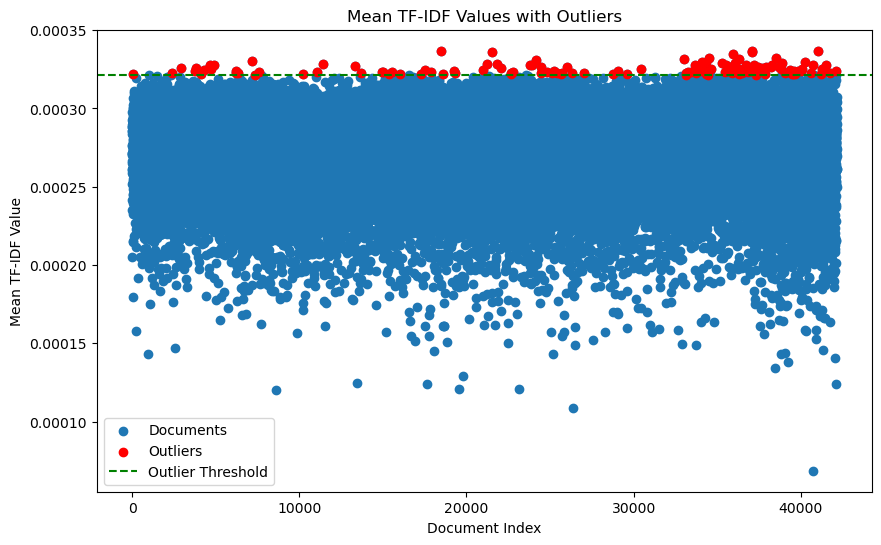

In [25]:
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix


# Compute the mean TF-IDF value for each document
doc_mean_tfidf = np.array(dtm_tfidf.mean(axis=1)).flatten()

# Calculate the overall mean and standard deviation of these mean values
mean = np.mean(doc_mean_tfidf)
std = np.std(doc_mean_tfidf)

# Define the threshold for outliers (e.g., mean + 2 * standard deviation)
threshold = mean + 2 * std

# Identify outliers as those documents whose mean TF-IDF value exceeds the threshold
outlier_indices = np.where(doc_mean_tfidf > threshold)[0]

# Culculate percentage of outliers
outlier_percentage = len(outlier_indices) / len(doc_mean_tfidf)
print(outlier_percentage)

# Generate outlier picture
plt.figure(figsize=(10, 6))
plt.scatter(range(len(doc_mean_tfidf)), doc_mean_tfidf, label='Documents')
plt.scatter(outlier_indices, doc_mean_tfidf[outlier_indices], color='red', label='Outliers')
plt.axhline(y=threshold, color='green', linestyle='--', label='Outlier Threshold')
plt.xlabel('Document Index')
plt.ylabel('Mean TF-IDF Value')
plt.title('Mean TF-IDF Values with Outliers')
plt.legend()
plt.show()

# Filter the DTM to only include non-outlier documents
non_outlier_mask = doc_mean_tfidf <= threshold
filtered_dtm = dtm_tfidf[non_outlier_mask]


We use the mean TF-IDF value of each document to do normalization for the data. We identify outliers as those documents with mean TF-IDF values significantly exceeding the average, determined as being beyond two standard deviations from the mean. These outliers, constituting 1.5% of our dataset, are presumed to contain a high frequency of unusual terms, possibly typographical errors or incorrect terminology. 

### b.Dimension Reduction
 We use UMAP (Uniform Manifold Approximation and Projection) as the choice for dimensionality reduction in this context. The reason being, it can effectively visualize high-dimensional datasets in lower-dimensional space, thereby revealing the natural clusters in the dataset.

We’ve chosen the parameters for UMAP as follows:random_state: given the stochastic nature of UMAP, we’ve used the random_state parameter to ensure reproducibility of results. n_neighbors: we’ve carefully selected this parameter which is 15 to balance between preserving the local and global structure of the data. min_dist: we use the default value 0.1 to control how tightly UMAP is allowed to pack points together in the lower-dimensional representation. A smaller value results in a “clumpier” visualization where points are packed closely together.n_components: it determined the dimensionality of the reduced space. In this case, we choose 2 and 3. metric: we’ve chosen the Euclidean metric for computing distance in the original high-dimensional space. This choice reflects the nature of the data, where features are all measured on compatible scales.


2-dimension

In [26]:
# pip install umap-learn
import umap.umap_ as umap


# Create an instance of the UMAP model
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1,  n_components=2, metric='euclidean')

# Fit the model to your TF-IDF data and transform the data
umap_embedding = reducer.fit_transform(filtered_dtm)

print(umap_embedding)

[[-9.2167    11.675886 ]
 [-9.501089  12.119407 ]
 [-9.678313  12.244846 ]
 ...
 [ 7.0924807  7.190606 ]
 [ 7.1343102  7.1406245]
 [ 6.8656926  7.4423614]]


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.title('UMAP Results', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [ ]:
# Statistical Measures
mean_distance = np.mean(np.linalg.norm(umap_embedding, axis=1))
median_distance = np.median(np.linalg.norm(umap_embedding, axis=1))

print(f'Mean distance from origin: {mean_distance}')
print(f'Median distance from origin: {median_distance}')

The mean and median distances from the origin are approximately 10.90 and 10.84, respectively. This suggests that the physician’s notes are spread out from the origin in the reduced dimensional space, indicating a diversity in the content. The closeness of the mean and median suggests a symmetrical distribution around the origin. 

3-dimension

In [ ]:
# Create an instance of the UMAP model
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean')

# Fit the model to your TF-IDF data and transform the data
umap_embedding = reducer.fit_transform(filtered_dtm)

print(umap_embedding)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], s=100)
plt.title('UMAP Results', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [ ]:
# Statistical Measures
mean_distance = np.mean(np.linalg.norm(umap_embedding, axis=1))
median_distance = np.median(np.linalg.norm(umap_embedding, axis=1))

print(f'Mean distance from origin: {mean_distance}')
print(f'Median distance from origin: {median_distance}')

The mean and median distances from the origin are approximately 11.53 and 12.88, respectively. This suggests that the physician’s notes are spread out from the origin in the reduced dimensional space, indicating a diversity in the content. The closeness of the mean and median suggests a symmetrical distribution around the origin. 